# Import library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## Download dataset

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Feature engineering

## Drop NaN

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

## Create new feature

In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


# Split dataset

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [12]:
train_dataset.shape, test_dataset.shape

((314, 10), (78, 10))

# Visualization dataset

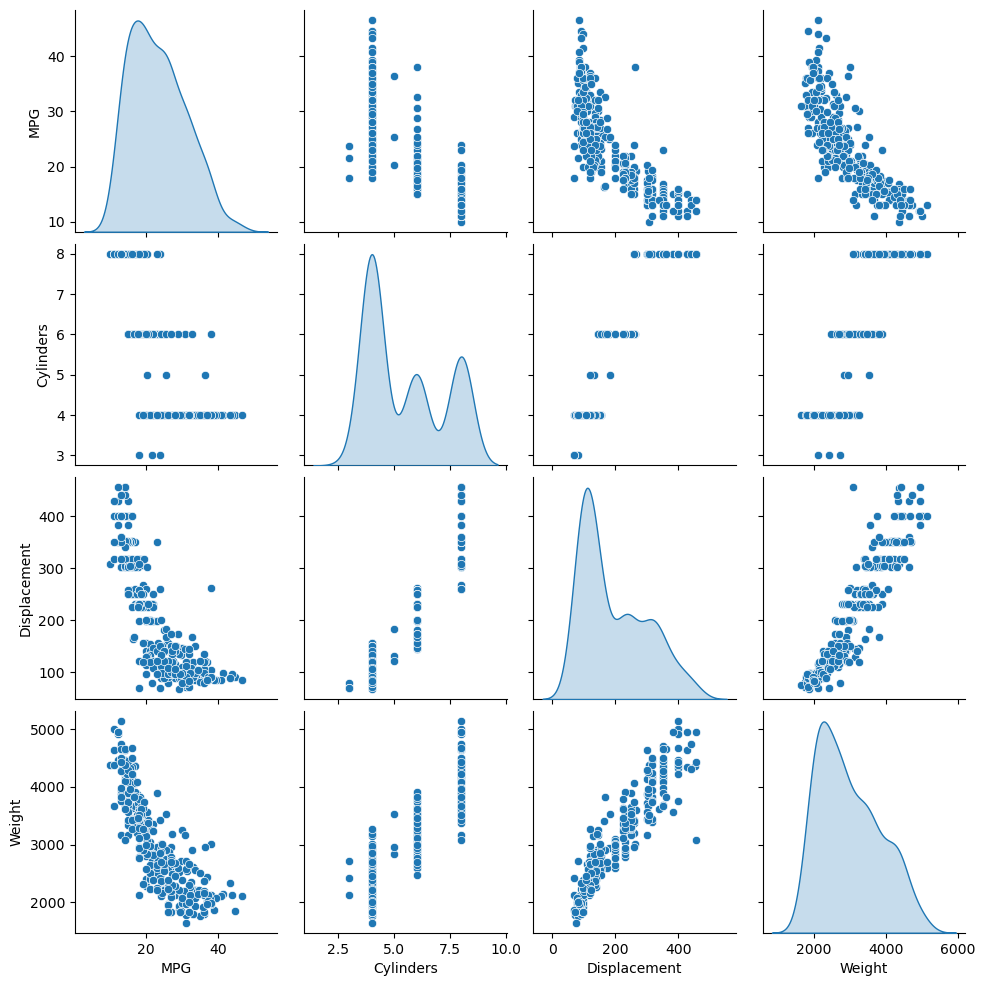

In [13]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


# Target

In [15]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Normalization

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [17]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [18]:
normalizer.adapt(np.array(train_features))

In [19]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [20]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Lineary regression

In [21]:
horsepower = np.array(train_features['Horsepower'])

In [22]:
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [23]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [24]:
horsepower_model.predict(horsepower[:10], verbose=0)

array([[ 0.065],
       [ 0.037],
       [-0.121],
       [ 0.092],
       [ 0.083],
       [ 0.033],
       [ 0.098],
       [ 0.083],
       [ 0.022],
       [ 0.037]], dtype=float32)

# Fit model

In [25]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [26]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs = 100,
    verbose=0,
    validation_split=0.2
)

CPU times: total: 1.09 s
Wall time: 3.11 s


# Evaluate model

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806043,4.188293,95
96,3.804383,4.192388,96
97,3.805635,4.211486,97
98,3.805006,4.187404,98
99,3.802472,4.197853,99


In [28]:
def plot_loss(history):
  plt.subplots(figsize=(8, 8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

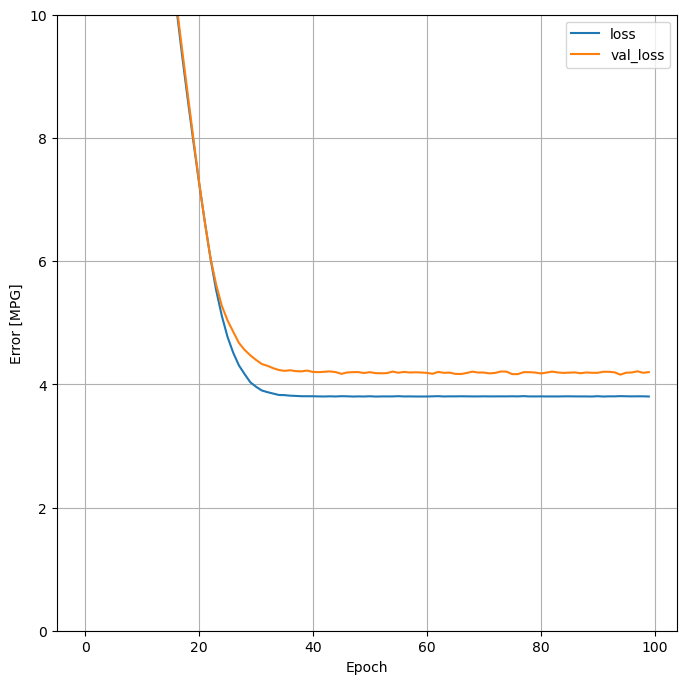

In [29]:
plot_loss(history)

In [30]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [31]:
test_results

{'horsepower_model': 3.646477222442627}

In [32]:
x = tf.linspace(0., 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [33]:
def plot_horsepower(x, y):
  plt.subplots(figsize=(10, 10))
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='r', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

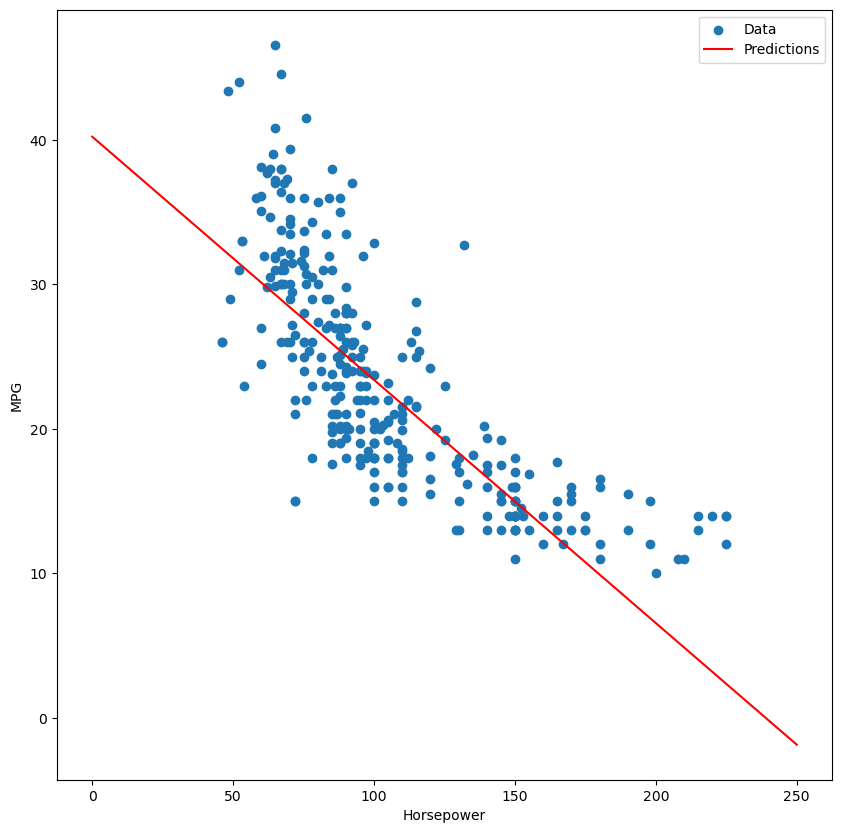

In [34]:
plot_horsepower(x, y)

In [35]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [36]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 45ms/step


array([[ 1.116],
       [-0.915],
       [ 0.6  ],
       [-0.538],
       [-0.488],
       [-0.643],
       [-0.506],
       [-3.345],
       [ 0.29 ],
       [ 0.679]], dtype=float32)

In [37]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.004],
       [ 0.37 ],
       [-0.003],
       [-0.73 ],
       [-0.496],
       [-0.767],
       [-0.103],
       [ 0.448],
       [ 0.417]], dtype=float32)>

In [38]:
linear_model.layers[1].bias

<tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>

In [39]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [40]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2
)

In [41]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.323],
       [ 0.039],
       [-1.339],
       [-3.321],
       [-0.888],
       [ 2.122],
       [ 0.259],
       [ 1.086],
       [-0.513]], dtype=float32)>

In [42]:
linear_model.layers[1].bias

<tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([23.077], dtype=float32)>

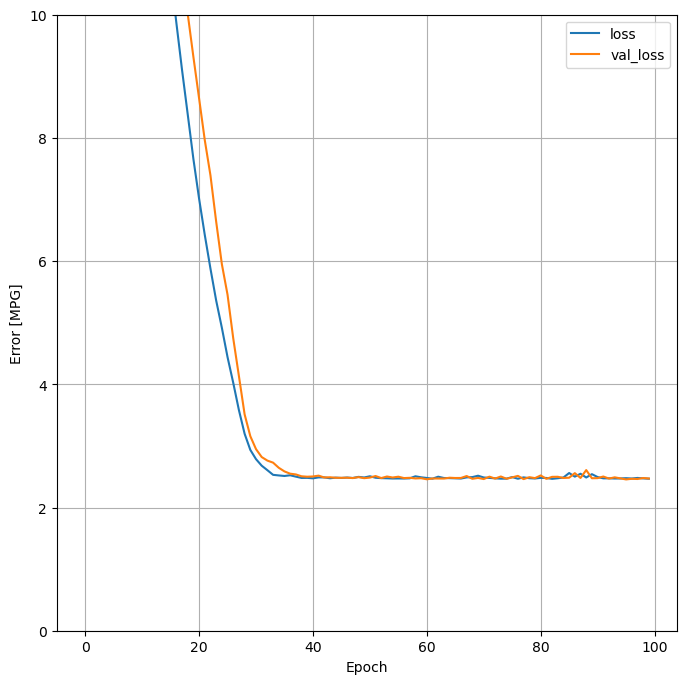

In [43]:
plot_loss(history)

In [44]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

In [45]:
test_results

{'horsepower_model': 3.646477222442627, 'linear_model': 2.516404867172241}

# Deep Neural Network

In [46]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss='mean_absolute_error'
  )
  return model

In [47]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [48]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [49]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 19.1 s
Wall time: 3.9 s


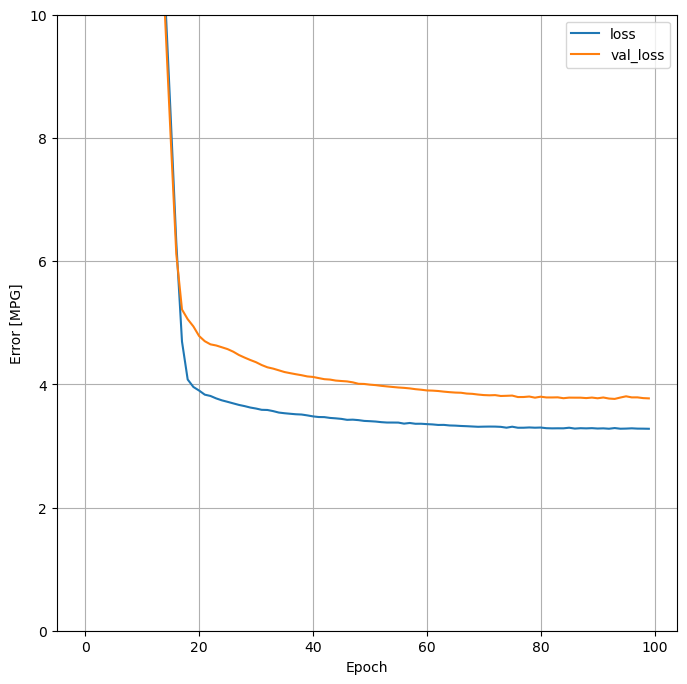

In [50]:
plot_loss(history)

In [51]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


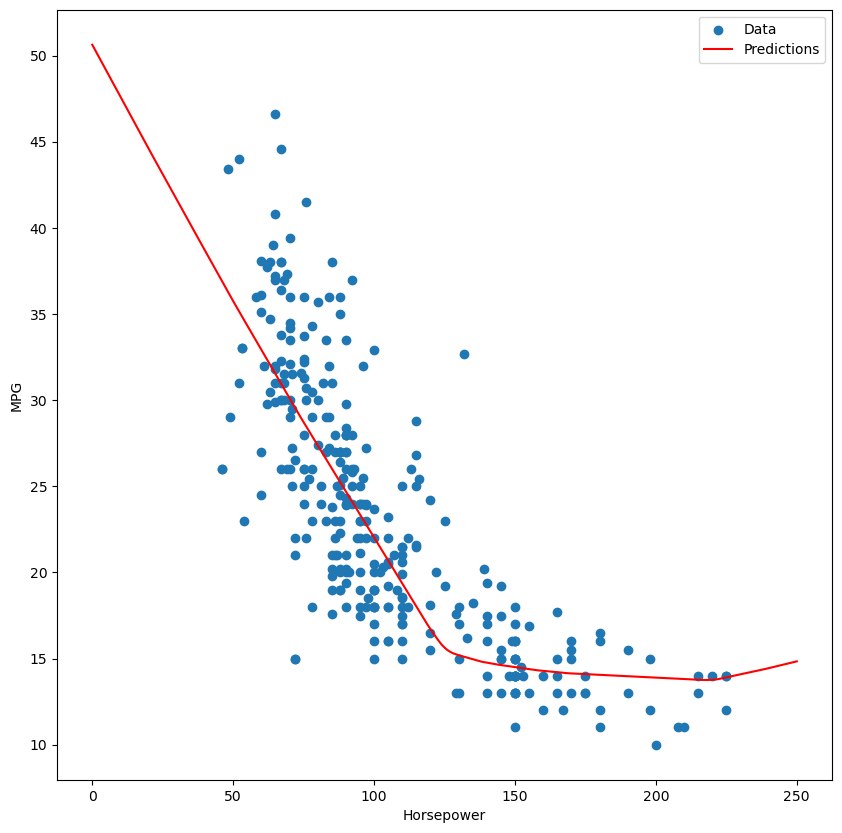

In [52]:
plot_horsepower(x, y)

In [53]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [54]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [55]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 18.7 s
Wall time: 3.96 s


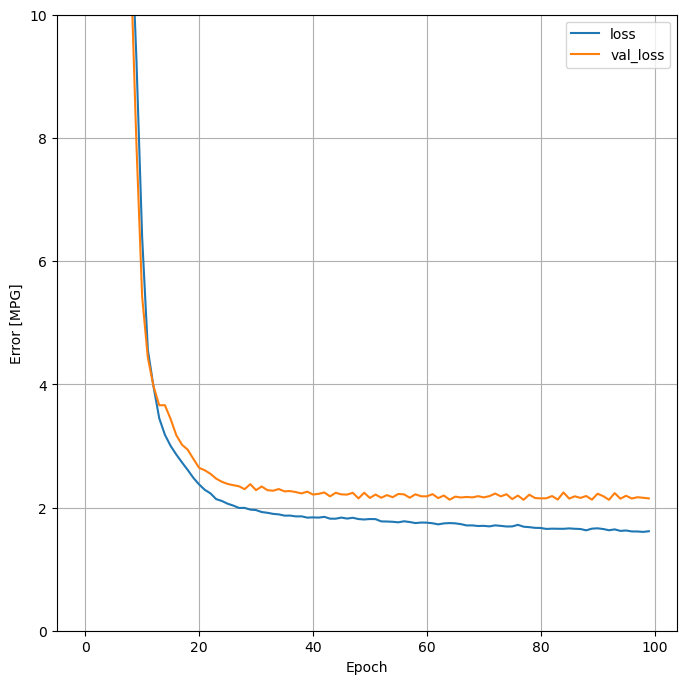

In [56]:
plot_loss(history)

In [57]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Summary

In [58]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646477
linear_model,2.516405
dnn_horsepower_model,2.969123
dnn_model,1.658922


In [59]:
test_predictions = dnn_model.predict(test_features).flatten()

3/3 [==============================] - 0s 8ms/step


In [60]:
test_predictions

array([15.905, 12.549, 12.977, 25.164, 20.46 , 13.037, 13.48 , 12.63 ,
       18.976, 31.522, 25.667, 26.485, 14.99 , 27.225, 12.927, 14.621,
       14.809, 13.402, 18.277, 13.021, 14.279, 25.83 , 19.67 , 21.016,
       30.566, 24.396, 16.404, 23.341, 17.253, 18.587, 28.106, 21.631,
       18.399, 21.11 , 26.923, 16.199, 18.696, 30.975, 29.891, 17.673,
       30.943, 29.028, 15.562, 37.056, 35.083, 35.576, 20.394, 21.382,
       19.426, 25.531, 31.186, 17.315, 31.941, 18.315, 17.821, 18.   ,
       32.987, 34.335, 22.058, 24.672, 39.64 , 32.838, 27.053, 26.864,
       31.729, 39.108, 36.405, 35.336, 33.616, 30.915, 21.772, 22.725,
       29.63 , 30.278, 36.147, 35.814, 37.98 , 30.058], dtype=float32)

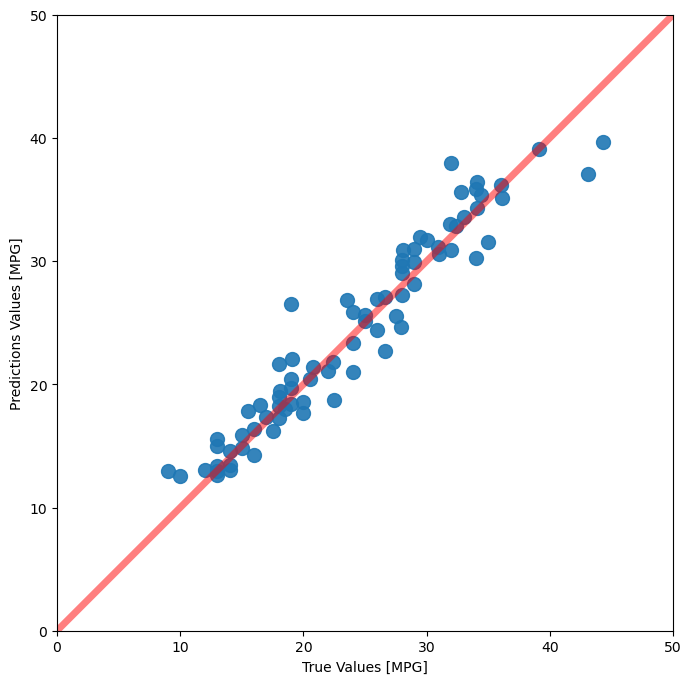

In [61]:
plt.figure(figsize=(8, 8))
ax = plt.axes(aspect='equal')

lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, color='r', linewidth=5, alpha=0.5)

plt.scatter(test_labels, test_predictions, alpha=0.9, s=100)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions Values [MPG]');

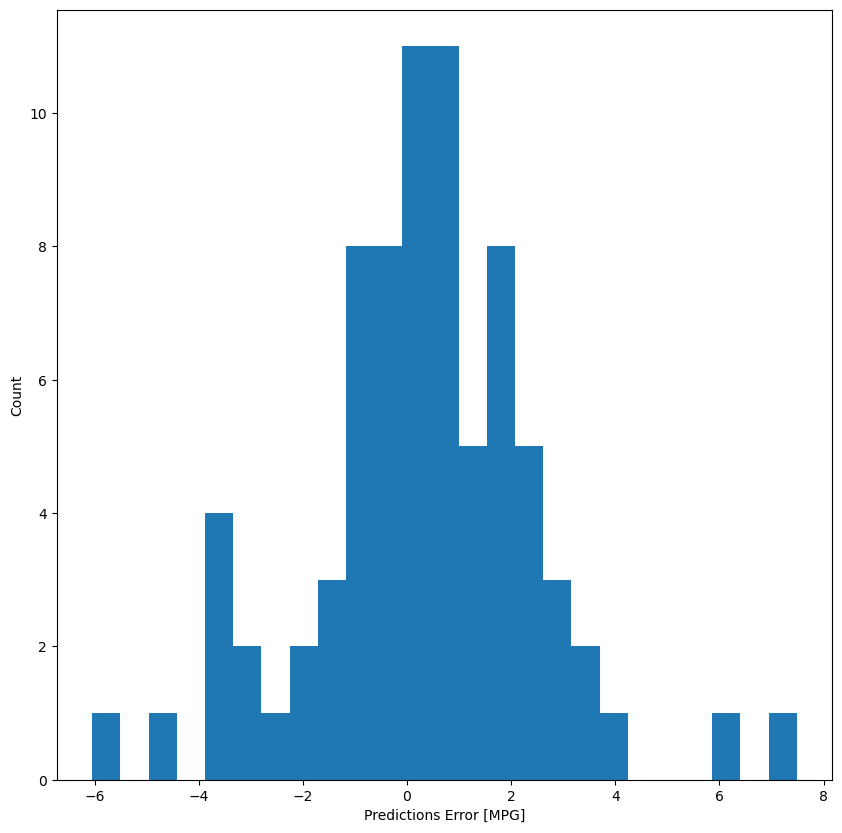

In [62]:
from seaborn.distributions import KDE
error = test_predictions - test_labels
plt.figure(figsize=(10, 10))
plt.hist(error, bins=25)
plt.xlabel('Predictions Error [MPG]')
plt.ylabel('Count');

In [63]:
dnn_model.save('dnn_model');

INFO:tensorflow:Assets written to: dnn_model\assets


In [64]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [65]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.646477
linear_model,2.516405
dnn_horsepower_model,2.969123
dnn_model,1.658922
reloaded,1.658922
